In [1]:
! pip install transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 16.0 MB/s eta 0:00:00


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
from diffusers import StableDiffusionPipeline, DiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [4]:
# configurations
height, width       = 512, 512
guidance_scale      = 8
custom_loss_scale   = 200
num_inference_steps = 50
batch_size          = 1

In [5]:
# large or small model

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float32
).to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
# Load SD concepts
sdconcepts = ['<morino-hon>', '<space-style>', '<tesla-bot>', '<midjourney-style>', ' <hanfu-anime-style>']

pipe.load_textual_inversion("sd-concepts-library/morino-hon-style")
pipe.load_textual_inversion("sd-concepts-library/space-style")
pipe.load_textual_inversion("sd-concepts-library/tesla-bot")
pipe.load_textual_inversion("sd-concepts-library/midjourney-style")
pipe.load_textual_inversion("sd-concepts-library/hanfu-anime-style")

# define seeds
seed_list = [1, 2, 3, 4, 5]

learned_embeds.bin:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

learned_embeds.bin:   0%|          | 0.00/3.84k [00:00<?, ?B/s]

learned_embeds.bin:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

learned_embeds.bin:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

learned_embeds.bin:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

In [20]:
import numpy as np
def custom_loss(images):

    # Gradient loss
    gradient_x = torch.abs(images[:, :, :, :-1] - images[:, :, :, 1:]).mean()
    gradient_y = torch.abs(images[:, :, :-1, :] - images[:, :, 1:, :]).mean()
    error = gradient_x + gradient_y
    #Variational loss
    # diff_x = torch.abs(images[:, :, :, :-1] - images[:, :, :, 1:])
    # diff_y = torch.abs(images[:, :, :-1, :] - images[:, :, 1:, :])
    # error = diff_x.mean() + diff_y.mean()

    return error

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1) # 0 to 1
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def pil_to_np(image):
    """
    Convert a PIL image to a NumPy array.

    Parameters:
    - image (PIL.Image.Image): PIL image to be converted.

    Returns:
    - numpy.ndarray: NumPy array representing the image.
    """
    return np.array(image)

def plot_images(images, row=1, col=5):
    """
    Plot a grid of PIL images.

    Parameters:
    - images (list): List of PIL images to be plotted.
    - row (int): Number of rows in the grid.
    - col (int): Number of columns in the grid.
    """

    if len(images) != row * col:
        raise ValueError("Number of images should match the product of row and col.")

    fig, axes = plt.subplots(row, col, figsize=(15, 3 * row), squeeze=False)

    for i in range(row):
        for j in range(col):
            idx = i * col + j
            if idx < len(images):
                np_image = pil_to_np(images[idx])
                axes[i, j].imshow(np_image)
                axes[i, j].axis('off')
            else:
                # If fewer images than expected, leave the subplot blank
                axes[i, j].axis('off')

    plt.show()

In [11]:
def generate_latents(prompts, seed_nums, loss_apply=False):

    generator = torch.manual_seed(seed_nums)

    # scheduler
    scheduler    = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = "scaled_linear", num_train_timesteps = 1000)
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

    # text embeddings of the prompt
    text_input = pipe.tokenizer(prompts, padding='max_length', max_length = pipe.tokenizer.model_max_length, truncation= True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    with torch.no_grad():
        text_embeddings = pipe.text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
          [""] * batch_size, padding="max_length", max_length= max_length, return_tensors="pt"
    )

    with torch.no_grad():
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings,text_embeddings]) # 2,77,768

    # random latent
    latents = torch.randn(
        (batch_size, pipe.unet.config.in_channels, height// 8, width //8),
        generator = generator,
    ) .to(torch.float16)


    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):

        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = pipe.unet(latent_model_input.to(torch.float32), t, encoder_hidden_states=text_embeddings)["sample"]
            #noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        if (loss_apply and i%5 == 0):

            latents = latents.detach().requires_grad_()
            #latents_x0 = scheduler.step(noise_pred,t, latents).pred_original_sample # this line does not work
            latents_x0 = latents - sigma * noise_pred

            # use vae to decode the image
            denoised_images = pipe.vae.decode((1/ 0.18215) * latents_x0).sample / 2 + 0.5 # range(0,1)

            loss = custom_loss(denoised_images) * custom_loss_scale
            print(f"Custom gradient loss {loss}")

            cond_grad = torch.autograd.grad(loss, latents)[0]
            latents = latents.detach() - cond_grad * sigma**2

        latents = scheduler.step(noise_pred,t, latents).prev_sample

    return latents

In [12]:
prompt= """Generate image of man with lion face and butterfly wings"""

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

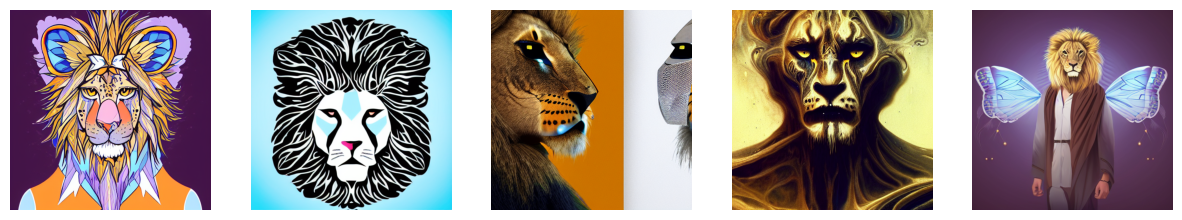

In [18]:
import gc
def generate_images(seed_list, sdconcepts, loss_flag = False):
    # after loss is applied
    latents_list = []
    for seed_no,sd in zip(seed_list, sdconcepts):
        prompts = [f'{prompt} {sd}']
        latents = generate_latents(prompts, seed_no, loss_apply=loss_flag)
        latents_list.append(latents)

    # show all
    latents_list = torch.vstack(latents_list)
    images = latents_to_pil(latents_list)
    plot_images(images, 1, len(seed_list))

  0%|          | 0/50 [00:00<?, ?it/s]

Custom gradient loss 3.397831439971924
Custom gradient loss 1.8297686576843262
Custom gradient loss 1.9089559316635132
Custom gradient loss 3.9746620655059814
Custom gradient loss 4.403022766113281
Custom gradient loss 5.940941333770752
Custom gradient loss 7.291110038757324
Custom gradient loss 8.306697845458984
Custom gradient loss 8.899075508117676
Custom gradient loss 9.328609466552734


  0%|          | 0/50 [00:00<?, ?it/s]

Custom gradient loss 3.3025455474853516
Custom gradient loss 4.380246162414551
Custom gradient loss 5.677600860595703
Custom gradient loss 9.911650657653809
Custom gradient loss 11.65797233581543
Custom gradient loss 12.48499584197998
Custom gradient loss 14.078876495361328
Custom gradient loss 14.938237190246582
Custom gradient loss 15.716856956481934
Custom gradient loss 16.34303092956543


  0%|          | 0/50 [00:00<?, ?it/s]

Custom gradient loss 6.383289337158203
Custom gradient loss 3.8805642127990723
Custom gradient loss 3.4297971725463867
Custom gradient loss 5.564738750457764
Custom gradient loss 5.506551265716553
Custom gradient loss 5.973170757293701
Custom gradient loss 6.643828868865967
Custom gradient loss 6.822854042053223
Custom gradient loss 7.600475788116455
Custom gradient loss 7.683743476867676


  0%|          | 0/50 [00:00<?, ?it/s]

Custom gradient loss 6.027558326721191
Custom gradient loss 6.090662002563477
Custom gradient loss 5.802453994750977
Custom gradient loss 6.27109432220459
Custom gradient loss 6.98696231842041
Custom gradient loss 7.686993598937988
Custom gradient loss 7.725642681121826
Custom gradient loss 8.408286094665527
Custom gradient loss 8.922626495361328
Custom gradient loss 9.668475151062012


  0%|          | 0/50 [00:00<?, ?it/s]

Custom gradient loss 1.2162353992462158
Custom gradient loss 1.708425521850586
Custom gradient loss 2.1357085704803467
Custom gradient loss 2.3571887016296387
Custom gradient loss 3.4909651279449463
Custom gradient loss 4.4973931312561035
Custom gradient loss 4.202547073364258
Custom gradient loss 4.491544246673584
Custom gradient loss 4.884675979614258
Custom gradient loss 5.240303993225098


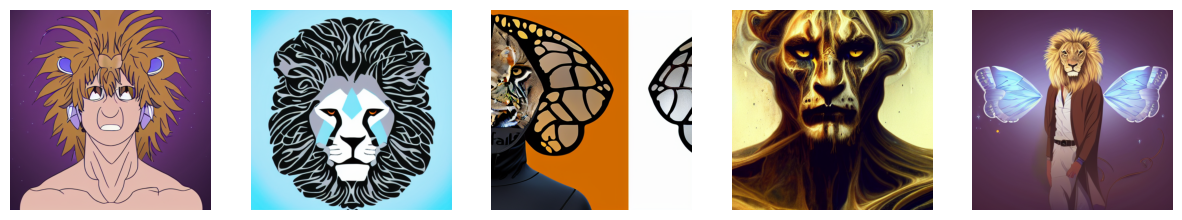

In [21]:
import gc
# after loss is applied
latents_collect = []
loss_type = False
for seed_no,sd in zip(seed_list, sdconcepts):

    prompts = [f'{prompt} {sd}']
    latents = generate_latents(prompts, seed_no, loss_apply=True)
    latents_collect.append(latents)

# show all
latents_collect = torch.vstack(latents_collect)
images = latents_to_pil(latents_collect)
plot_images(images, 1, len(seed_list))